# Generative Adversarial Network Augmented dataset

In [9]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
train_classifier = False

if train_classifier:
    # Classifier parameters
    C_learning_rate = 0.01
    C_training_epochs = 200
    C_batch_size = 100
    C_display_step = 20

    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
    y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

    # Set model weights
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))

    # Construct model
    C_pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

    # Minimize error using cross entropy
    C_cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(C_pred), reduction_indices=1)) 

    # Gradient Descent
    C_optimizer = tf.train.GradientDescentOptimizer(C_learning_rate).minimize(C_cost)
else:
    W = tf.get_variable("W", shape=[784,10])
    b = tf.get_variable("b", shape=[10])

In [12]:
# Training Params
num_steps = 50
batch_size = 32
learning_rate = 0.0002
augmented_stack_size = 3

# Network Params
image_dim = 784*3 # 28*28 pixels * 3 images
gen_hidden_dim = 256*3
disc_hidden_dim = 256
noise_dim = 100*3 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [13]:
train_generator=True
if train_generator:
    # Store layers weight & bias
    weights = {
        'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
        'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
        'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
        'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
    }
    biases = {
        'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
        'gen_out': tf.Variable(tf.zeros([image_dim])),
        'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
        'disc_out': tf.Variable(tf.zeros([1])),
    }
else:
    weights =  {
        'gen_hidden1': tf.get_variable("gen_hidden1", shape=[noise_dim, gen_hidden_dim]),
        'gen_out': tf.get_variable("gen_out", shape=[gen_hidden_dim, image_dim]),
        'disc_hidden1': tf.get_variable("disc_hidden1", shape=[image_dim, disc_hidden_dim]),
        'disc_out': tf.get_variable("disc_out", shape=[disc_hidden_dim, 1]),
    }
    biases = {
        'gen_hidden1': tf.get_variable("b_gen_hidden1", shape=[gen_hidden_dim]),
        'gen_out': tf.get_variable("b_gen_out", shape=[image_dim]),
        'disc_hidden1': tf.get_variable("b_disc_hidden1", shape=[disc_hidden_dim]),
        'disc_out': tf.get_variable("b_disc_out", shape=[1]),
    }

In [14]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [15]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

In [16]:
if train_generator:
    # Training
    total_batch = int(mnist.train.num_examples/(batch_size*augmented_stack_size))
    for i in range(1, num_steps+1):
        # Prepare Data
        ave_gl = 0
        ave_dl = 0
        # Augmented MNIST
        for j in range(total_batch):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, _ = mnist.train.next_batch(augmented_stack_size*batch_size)
            batch_x = batch_x.reshape((batch_size,batch_x.shape[1]*augmented_stack_size))
            # Generate noise to feed to the generator
            z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

            # Train
            feed_dict = {disc_input: batch_x, gen_input: z}
            _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                    feed_dict=feed_dict)
            ave_gl += gl / total_batch
            ave_dl += dl / total_batch
        
            if j % 50 == 0:
                sys.stdout.write("\rStep %i: %d%%" % (i, j/total_batch*100))
                sys.stdout.flush()
        sys.stdout.write("\rStep %i: %d%%" % (i, 100))
        sys.stdout.flush()
        
        if i % 5 == 0 or i == 1:
            print('. Generator Loss: %f, Discriminator Loss: %f' % (ave_gl, ave_dl))

Step 1: 100%. Generator Loss: 3.213269, Discriminator Loss: 0.170921
Step 5: 100%. Generator Loss: 3.608382, Discriminator Loss: 0.124624
Step 10: 100%. Generator Loss: 2.195766, Discriminator Loss: 0.318821
Step 15: 100%. Generator Loss: 3.229067, Discriminator Loss: 0.163811
Step 20: 100%. Generator Loss: 3.411138, Discriminator Loss: 0.192362
Step 25: 100%. Generator Loss: 3.590957, Discriminator Loss: 0.215461
Step 30: 100%. Generator Loss: 3.648595, Discriminator Loss: 0.233022
Step 35: 100%. Generator Loss: 3.359706, Discriminator Loss: 0.319050
Step 40: 100%. Generator Loss: 3.071941, Discriminator Loss: 0.406187
Step 45: 100%. Generator Loss: 2.783863, Discriminator Loss: 0.496801
Step 50: 100%. Generator Loss: 2.724861, Discriminator Loss: 0.610818


In [17]:
if train_generator:
    saver1 = tf.train.Saver(weights)
    saver1.save(sess, "./saved/gan_aug_batches__weights.ckpt")
    saver2 = tf.train.Saver(biases)
    saver2.save(sess, "./saved/gan_aug_batches_biases.ckpt")
else:
    saver1 = tf.train.Saver(weights)
    saver1.restore(sess, "./saved/gan_aug_batches_weights.ckpt")
    saver2 = tf.train.Saver(biases)
    saver2.restore(sess, "./saved/gan_aug_batches_biases.ckpt")

In [18]:
if train_classifier:
    # Start classifier training
    for epoch in range(C_training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/C_batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(C_batch_size)
            # Fit training using batch data
            _, c = sess.run([C_optimizer, C_cost], feed_dict={x: batch_xs,y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % C_display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(C_pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    with sess.as_default():
        print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

    C_saver = tf.train.Saver({'W':W,'b':b})
    C_saver.save(sess, "./saved/classifier_weights.ckpt")

else: #if training classifier, load weights
    C_saver = tf.train.Saver([W,b])
    C_saver.restore(sess, "./saved/classifier_weights.ckpt")

INFO:tensorflow:Restoring parameters from ./saved/classifier_weights.ckpt


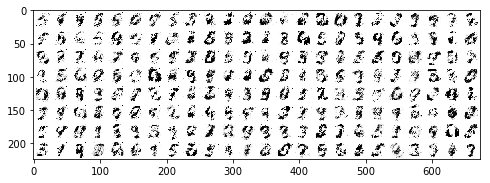

In [19]:
# Testing
# Generate images from noise, using the generator network.
n = 8
canvas = np.empty((28 * n, 28 * n * augmented_stack_size))
z = np.random.uniform(-1., 1., size=[n*n, noise_dim])
g = sess.run(gen_sample, feed_dict={gen_input: z})
g = -1 * (g - 1)
for k in range(augmented_stack_size):
    for i in range(n):
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, k*28*n + j * 28: k*28*n + (j + 1) * 28] = g[i*n+j,k*784:(k+1)*784].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [20]:
# classify generated images
y_plot = {}
y_plot_pred = np.zeros(n*n)
g = -1 * (g - 1)
for k in range(augmented_stack_size):
    y_plot[k]= tf.nn.softmax(tf.matmul(g[:,k*784:(k+1)*784], W) + b).eval(session=sess)
    y_plot_pred += np.argmax(y_plot[k],1)*(10**k)

In [21]:
unique, counts = np.unique(y_plot_pred, return_counts=True)
d_plot = dict(zip(unique, counts))
y_plot_pred

array([  35.,  829.,  224.,  325.,  724.,  460.,  360.,  225.,  265.,
        554.,  456.,  624.,  729.,  485.,  621.,   53.,  238.,  502.,
        553.,  536.,   62.,  794.,   35.,  785.,  831.,  785.,  426.,
        328.,  755.,  320.,  362.,  534.,  367.,  326.,  798.,   33.,
        985.,   42.,  412.,  228.,  367.,  849.,  440.,  486.,  665.,
        428.,  414.,   72.,  227.,  624.,  329.,  391.,  493.,  483.,
         33.,  527.,  635.,  551.,  538.,  218.,  302.,  356.,  627.,  755.])

In [22]:
counts_test = dict.fromkeys(range(1000),0)

In [35]:
#run this cell 10 times, small batches prevent hanging

n_test=10000
# Noise input.
z = np.random.uniform(-1., 1., size=[n_test, noise_dim])
# Generate image from noise.
g_test = sess.run(gen_sample, feed_dict={gen_input: z})

# classify generated images
y = {}
y_pred = np.zeros(n_test)
for k in range(augmented_stack_size):
    y[k] = tf.nn.softmax(tf.matmul(g_test[:,k*784:(k+1)*784], W) + b).eval(session=sess)
    y_pred += np.argmax(y[k],1)*10**k
unique, counts = np.unique(y_pred, return_counts=True)
for key,count in zip(unique, counts):
    counts_test[key]+=count
print(sum(counts_test.values())) #check if it's total number of tests we want
#counts_test

70000


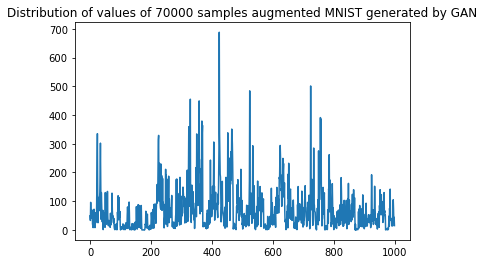

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(counts_test.keys()),list(counts_test.values()))
plt.title('Distribution of values of '+str(sum(counts_test.values()))+' samples augmented MNIST generated by GAN')

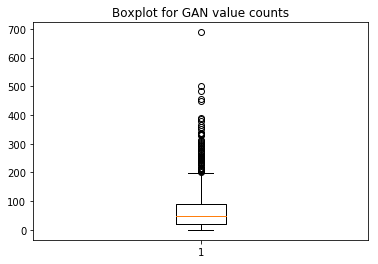

In [38]:
plt.boxplot(list(counts_test.values()))
plt.title("Boxplot for GAN value counts")

In [39]:
#chekhov_counts_test = copy over from other file

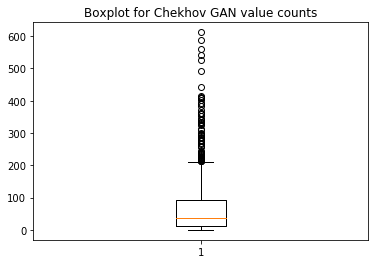

In [40]:
plt.boxplot(list(chekhov_counts_test.values()))
plt.title("Boxplot for Chekhov GAN value counts")

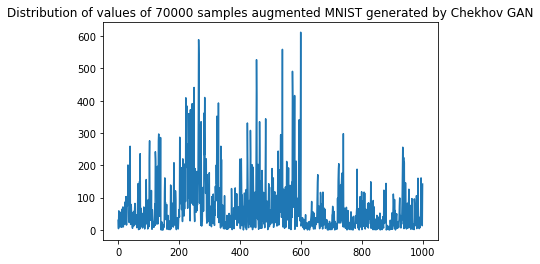

In [41]:
plt.plot(list(chekhov_counts_test.keys()),list(chekhov_counts_test.values()))
plt.title('Distribution of values of '+str(sum(chekhov_counts_test.values()))+' samples augmented MNIST generated by Chekhov GAN')

In [42]:
counts_test

{0: 49,
 1: 33,
 2: 96,
 3: 41,
 4: 47,
 5: 63,
 6: 61,
 7: 69,
 8: 21,
 9: 15,
 10: 8,
 11: 38,
 12: 36,
 13: 72,
 14: 44,
 15: 29,
 16: 8,
 17: 60,
 18: 24,
 19: 55,
 20: 43,
 21: 29,
 22: 141,
 23: 273,
 24: 335,
 25: 121,
 26: 25,
 27: 113,
 28: 88,
 29: 95,
 30: 67,
 31: 110,
 32: 130,
 33: 199,
 34: 302,
 35: 157,
 36: 37,
 37: 130,
 38: 89,
 39: 52,
 40: 28,
 41: 42,
 42: 68,
 43: 1,
 44: 43,
 45: 32,
 46: 26,
 47: 53,
 48: 59,
 49: 9,
 50: 130,
 51: 38,
 52: 127,
 53: 80,
 54: 20,
 55: 70,
 56: 30,
 57: 134,
 58: 50,
 59: 21,
 60: 15,
 61: 19,
 62: 33,
 63: 14,
 64: 16,
 65: 18,
 66: 9,
 67: 58,
 68: 17,
 69: 20,
 70: 28,
 71: 41,
 72: 128,
 73: 70,
 74: 44,
 75: 49,
 76: 43,
 77: 25,
 78: 40,
 79: 12,
 80: 4,
 81: 1,
 82: 4,
 83: 19,
 84: 6,
 85: 17,
 86: 1,
 87: 22,
 88: 6,
 89: 1,
 90: 62,
 91: 38,
 92: 119,
 93: 40,
 94: 35,
 95: 113,
 96: 60,
 97: 43,
 98: 64,
 99: 12,
 100: 0,
 101: 8,
 102: 10,
 103: 8,
 104: 2,
 105: 3,
 106: 12,
 107: 6,
 108: 21,
 109: 9,
 110: 6,
 11